# Analysis of AF predictions with regard to domain insertions

### Import 

Import packages:

In [1]:
import sys
sys.path.append('../')
import pickle
import numpy as np
import pandas as pd
import Bio
from Bio import SeqUtils
from Bio.PDB import *
from Bio.PDB import PDBParser
from Bio import pairwise2
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib as matplotlib


# set styles
plt.style.use('./utils/domain_ins.mplstyle')

Import data and set dirs

In [23]:
#general input folder
base = '/work/projects/project01640/jm/domain_insertion/DI_screen'
data_folder = f'{base}/analysis/output_datasets'
fig_folder = f'{base}/analysis/figures'
prot_path = f'{base}/analysis/input_data/hybrid_prediction_screen'

# impoert analysis dict
with open(f'{data_folder}/analysis_dict.pickle', 'rb') as input:
    analysis_dict = pickle.load(input)
input.close()

#import datasets
with open(f'{data_folder}/proteins_training.pickle', 'rb') as input:
    full_dataset = pickle.load(input)
input.close()

protein_combinations = [['AraC', 'PDZ']]


Functions:

In [24]:
def get_pLDDT(structure):
    '''
    Extracts the pLDDT score for the given structure
    '''
    pLDDT_score = []
    for chain in structure[0]: 
        for residue in chain:
            for atom in residue:
                if atom.full_id[4][0] == 'CA':
                    pLDDT_score.append(atom.bfactor)
    return pLDDT_score


### Process Data

In [31]:
# Create protein sequence df
import glob
positions = pd.Series(glob.glob('./input_data/hybrid_prediction_screen/*.pdb'))
positions = positions.str.split('/', expand=True)[3]
positions = positions.str.split('_', expand=True).iloc[:,:3]

,0,1,2
0,AraC,M244,PDZ
1,AraC,Q158,PDZ
2,AraC,N252,PDZ
3,AraC,Y147,PDZ
4,AraC,N285,PDZ
...,...,...,...
287,AraC,K267,PDZ
288,AraC,L32,PDZ
289,AraC,G53,PDZ
290,AraC,R67,PDZ


In [32]:
# Import all the pdb files
parser = PDBParser()
PDBs = {}
for combination in protein_combinations:
    PDBs[f'{combination[0]}_{combination[1]}'] = {}

for idx, pos in positions.iterrows():
    protein = pos[0]
    position = pos[1]
    domain = pos[2]
    PDBs[f'{protein}_{domain}'][f'{protein}_{position}_{domain}'] = {'structure':{}, 'pLDDT':{}, 'RMSD':{}}
    PDBs[f'{protein}_{domain}'][f'{protein}_{position}_{domain}'] = {'structure':{}, 'pLDDT':{}, 'RMSD':{}}
    PDBs[f'{protein}_{domain}'][f'{protein}_{position}_{domain}']['structure'] = parser.get_structure(position, f'{prot_path}/{protein}_{position}_{domain}_unrelaxed_rank_1_model_3.pdb')
    PDBs[f'{protein}_{domain}'][f'{protein}_{position}_{domain}']['pLDDT'] = get_pLDDT(PDBs[f'{protein}_{domain}'][f'{protein}_{position}_{domain}']['structure'])
    PDBs[f'{protein}_{domain}'][f'{protein}_{position}_{domain}']['structure'] = parser.get_structure(position, f'{prot_path}/{protein}_{position}_{domain}_unrelaxed_rank_1_model_3.pdb')
    PDBs[f'{protein}_{domain}'][f'{protein}_{position}_{domain}']['pLDDT'] = get_pLDDT(PDBs[f'{protein}_{domain}'][f'{protein}_{position}_{domain}']['structure'])

In [33]:
#dump the current dataset to pickle
with open(f'{data_folder}/PDBs.pickle', 'wb') as f:
    pickle.dump(PDBs, f) 
f.close() 

In [37]:
# Import the structures of the WT proteins
#AraC_wt_structure = parser.get_structure('AraC', f'/work/projects/project01640/jm/domain_insertion/pdb_files/AraC_AF.pdb')
parser = PDBParser()
WT_proteins = {}
protein_names = ['AraC', 'PDZ']
for protein in protein_names:
    WT_proteins[protein] = {}
    WT_proteins[protein]['structure'] = parser.get_structure(protein, f'{prot_path}/{protein}_unrelaxed_rank_1_model_3.pdb')

In [38]:
fusion_seqs = {}
for combination in protein_combinations:
    fusion_seqs[f'{combination[0]}_{combination[1]}'] = {}

#get some data for the structure alignment
for protein in protein_names:
    WT_proteins[protein]['seq'] = ''
    for res in WT_proteins[protein]['structure'].get_residues():
        WT_proteins[protein]['seq'] += SeqUtils.IUPACData.protein_letters_3to1[res.get_resname().title()]

for protein in protein_names:
    WT_proteins[protein]['res'] = []
    for res in WT_proteins[protein]['structure'].get_residues():
        WT_proteins[protein]['res'].append(res['CA'])

for combination in protein_combinations:
    try:
        for idx, AA in enumerate(WT_proteins[combination[0]]['seq']):
            fusion_seqs[f'{combination[0]}_{combination[1]}'][f'{combination[0]}_{AA}{idx+1}_{combination[1]}'] = WT_proteins[combination[0]]['seq'][:idx+1] + WT_proteins[combination[1]]['seq'] + WT_proteins[combination[0]]['seq'][idx+1:]
    except:
        pass

In [ ]:
RMS = {}
for comb in protein_combinations:
    RMS[f'{comb[0]}_{comb[1]}'] = {}
    RMS[f'{comb[0]}_{comb[1]}'][f'{comb[0]}_rms_values'] = []
    RMS[f'{comb[0]}_{comb[1]}'][f'{comb[1]}_rms_values'] = []

y = 0
for combination, comb_dict in PDBs.items():
        #if combination == 'AraC_PDZ':
        for variant_name, variant in comb_dict.items():
            # align the fusion protein to the parent protein and determin insertion
            alignments = pairwise2.align.globalxs(WT_proteins[combination.split('_')[0]]['seq'], fusion_seqs[combination][variant_name], -1000, -1)
            start = alignments[0][0].find('-')
            end = alignments[0][0].rfind('-')
            insert_alignment = range(start +1, end +2)
            
            #split pLDDT score by parent and insert
            variant['pLDDT_insert'] = variant['pLDDT'][start:end+1]
            variant['pLDDT_parent'] = variant['pLDDT'][:start] + variant['pLDDT'][end+1:]
            #print(variant['pLDDT_insert'])
            # gather th coordinates for the alignment
            candidate_res_ins = []
            candidate_res_par = []
            variant['RMSD_parent'] = []
            variant['RMSD_insert'] = []
            for res in variant['structure'].get_residues():            
                if res.get_id()[1] in insert_alignment:
                    candidate_res_ins.append(res['CA'])
                else: 
                    candidate_res_par.append(res['CA'])

            # perform structure alignment and get rms
            super_imposer = Bio.PDB.Superimposer()
            super_imposer.set_atoms(WT_proteins[combination.split('_')[1]]['res'], candidate_res_ins)
            super_imposer.apply(variant['structure'].get_atoms())
            RMS[f'{combination.split("_")[0]}_{combination.split("_")[1]}'][f'{combination.split("_")[1]}_rms_values'].append(super_imposer.rms)
            for idx, atom in enumerate(candidate_res_ins):
                variant['RMSD_insert'].append(atom - WT_proteins[combination.split('_')[1]]['res'][idx])

            super_imposer.set_atoms(WT_proteins[combination.split('_')[0]]['res'], candidate_res_par)
            super_imposer.apply(variant['structure'].get_atoms())
            RMS[f'{combination.split("_")[0]}_{combination.split("_")[1]}'][f'{combination.split("_")[0]}_rms_values'].append(super_imposer.rms)
            for idx, atom in enumerate(candidate_res_par):
                    variant['RMSD_parent'].append(atom - WT_proteins[combination.split('_')[0]]['res'][idx])

### Analysis

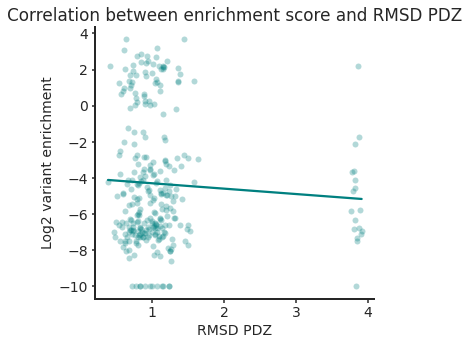

In [41]:
def correlation(x, y, name):
    sns.set_style("ticks")
    data = pd.DataFrame(list(zip(list(x),y)), columns=['enrichment', 'property'])
    data.dropna(inplace=True)
    plt.figure(figsize=(5,5))
    plt.rcParams['axes.linewidth'] = 2
    g = sns.regplot(data=data, x='property', y='enrichment', color='#008080', ci=None, 
        scatter_kws={'alpha':.3, 'linewidth':0}, line_kws={'alpha':1})
    plt.xlabel(name)
    plt.ylabel("Log2 variant enrichment")
    sns.despine()
    #g.legend.remove()
    plt.title(f"Correlation between enrichment score and {name}")

# Plot correlations between structures and enrichments
correlation(full_dataset['AraC']['2']['log'], RMS['AraC_PDZ']['PDZ_rms_values'], 'RMSD PDZ')

### Merge Data to df and sort by sequence:

In [42]:
#pack data into dfs
predict_data = {}
for combination in protein_combinations:
    predict_data[f'{combination[0]}_{combination[1]}'] = {}
    predict_data[f'{combination[0]}_{combination[1]}']['pLDDT_parent'] = {}
    predict_data[f'{combination[0]}_{combination[1]}']['pLDDT_insert'] = {}
    predict_data[f'{combination[0]}_{combination[1]}']['RMSD_parent'] = {}
    predict_data[f'{combination[0]}_{combination[1]}']['RMSD_insert'] = {}
    for variant_name, variant in PDBs[f'{combination[0]}_{combination[1]}'].items():
        predict_data[f'{combination[0]}_{combination[1]}']['pLDDT_parent'][variant_name] = variant['pLDDT_parent']
        predict_data[f'{combination[0]}_{combination[1]}']['pLDDT_insert'][variant_name] = variant['pLDDT_insert']
        predict_data[f'{combination[0]}_{combination[1]}']['RMSD_parent'][variant_name] = variant['RMSD_parent']
        predict_data[f'{combination[0]}_{combination[1]}']['RMSD_insert'][variant_name] = variant['RMSD_insert']
    #get residue order
    predict_data[f'{combination[0]}_{combination[1]}'][f'{combination[0]}_AA'] = []
    for position, AA in enumerate(WT_proteins[combination[0]]['seq']):
        predict_data[f'{combination[0]}_{combination[1]}'][f'{combination[0]}_AA'].append(f'{AA}{position + 1}')
    
    #create and process dfs
    for name, dataset in predict_data[f'{combination[0]}_{combination[1]}'].items():
        if name != f'{combination[0]}_AA':
            dataset = pd.DataFrame.from_dict(dataset)
            dataset.columns = dataset.columns.str.replace(f'{combination[0]}_','')
            dataset.columns = dataset.columns.str.replace(f'_{combination[1]}','')
            predict_data[f'{combination[0]}_{combination[1]}'][name] = dataset.reindex(predict_data[f'{combination[0]}_{combination[1]}'][f'{combination[0]}_AA'], axis=1)

pLDDT_parent


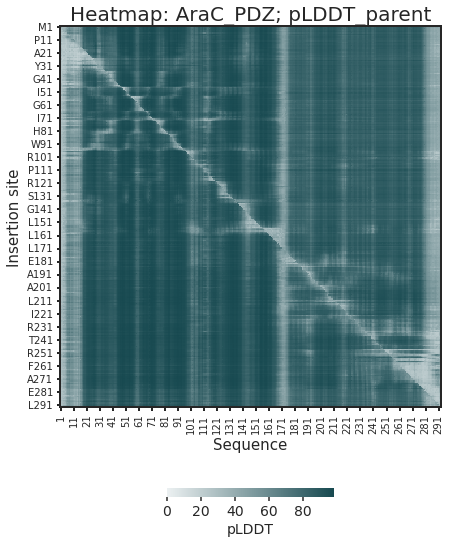

pLDDT_insert


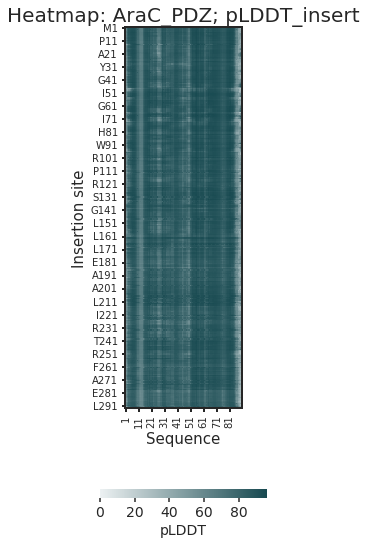

RMSD_parent


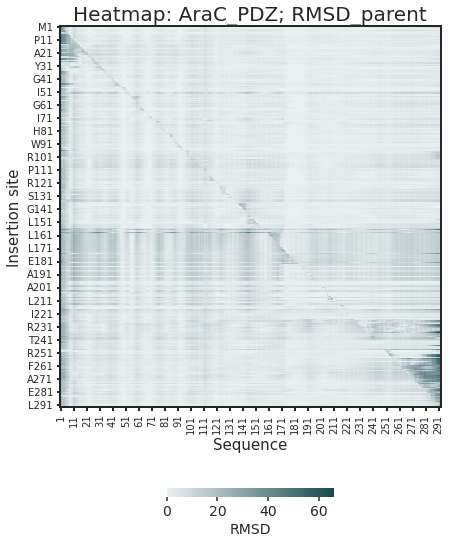

RMSD_insert


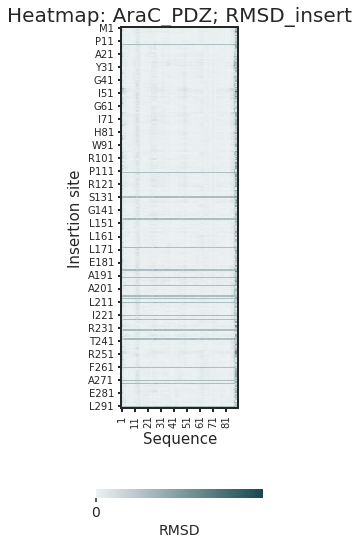

In [43]:
# Plot position-wise correlations
for combination, data_dict in predict_data.items():
    for name, dataset in data_dict.items():
        if name != f'{combination.split("_")[0]}_AA':
            print(name)
            sns.set_style("ticks")
            plt.figure(figsize=(10,10))
            ax =sns.heatmap(data=dataset.T, cmap=sns.light_palette('#174950', as_cmap=True), square=True, robust=False, vmin=0,# vmax=100,
                            cbar_kws={'label': name.split('_')[0], 'shrink':.3, 'orientation':'horizontal', 'ticks': [0, 20, 40, 60, 80, 100], 'extend':'neither'})
            plt.title(f"Heatmap: {combination}; {name}", fontsize=20, y=1.01)
            for _, spine in ax.spines.items():
                spine.set_visible(True)
                spine.set_linewidth(2)
            ax.yaxis.set_tick_params(width=2)
            ax.xaxis.set_tick_params(width=2)
            ax.set_xticks(np.arange(.5, len(dataset.iloc[:,0]) +.5, 10))
            ax.set_xticklabels(np.arange(1, len(dataset.iloc[:,0])+1, 10), fontsize=10)
            ax.set_yticks(np.arange(.5, len(dataset.iloc[0,:]) +.5, 10))
            ax.set_yticklabels(dataset.columns[::10], fontsize=10)
            ax.set_xlabel("Sequence", fontsize = 15)
            ax.set_ylabel("Insertion site", fontsize = 15)
            plt.savefig(f"{fig_folder}/feature_correlation_{combination}_{name}.svg", bbox_inches="tight")
            plt.show()
            plt.close()

#sns.diverging_palette(187, 10, s=100, l=25, as_cmap=True)
#sns.light_palette('#174950', as_cmap=True)

In [44]:
#dump the current dataset to pickle
with open(f'{data_folder}/predict_data.pickle', 'wb') as f:
    pickle.dump(predict_data, f) 
f.close() 

In [53]:
correlations = {}
for pair, data_dict in predict_data.items():
        for feature, dataset in data_dict.items():
            correlations_list = []
            if isinstance(dataset, pd.DataFrame):
                for position, values in dataset.iterrows():
                    x = pd.Series((analysis_dict[f"AraC_PDZ"]['12']['log'] + analysis_dict[f"AraC_PDZ"]['22']['log'])/2)
                    correlations_list.append(values.reset_index(drop=True).corr(x, method='spearman'))
                correlations[f'{pair}_{feature}'] = correlations_list


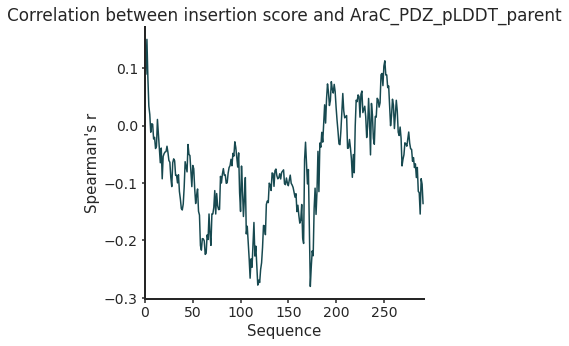

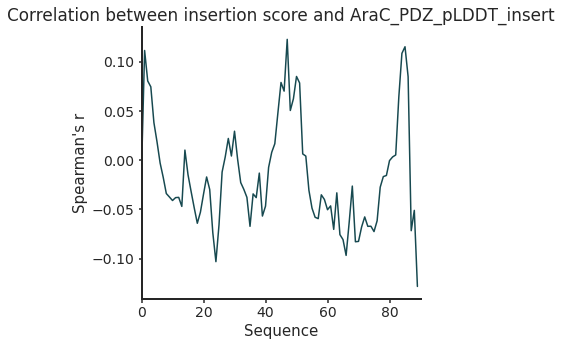

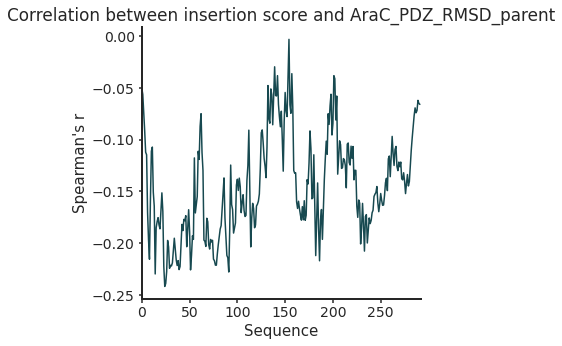

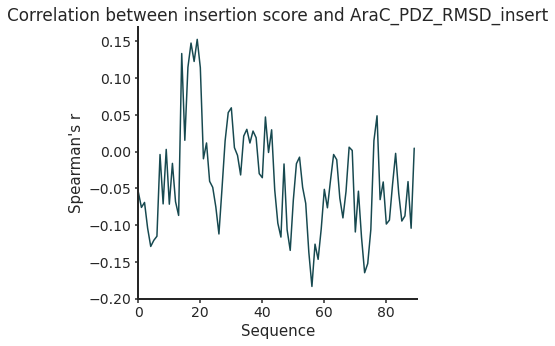

In [54]:
def insertion_line_plot(dataset, title):
    sns.set_style("ticks")
    plt.figure(figsize=(5,5))
    ax =sns.lineplot(data=pd.DataFrame(dataset), legend=False, palette={'#174950'})
    plt.title(title)
    sns.despine()
    ax.set(xlim=(0, len(dataset)))
    ax.set_xlabel("Sequence", fontsize = 15)
    ax.set_ylabel("Spearman's r", fontsize = 15)
    plt.savefig(f"{fig_folder}/feature_correlation_{name}.svg", bbox_inches="tight")
    plt.show()
    plt.close()

for name, dataset in correlations.items():
    insertion_line_plot(dataset, f"Correlation between insertion score and {name}")